# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


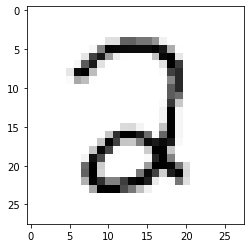

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2477
Training Accuracy: 0.5785, Testing Accuracy: 0.5675



Epoch 10, Loss 0.2212
Training Accuracy: 0.8267, Testing Accuracy: 0.8201



Epoch 20, Loss 0.1353
Training Accuracy: 0.8911, Testing Accuracy: 0.9052



Epoch 30, Loss 0.0746
Training Accuracy: 0.9238, Testing Accuracy: 0.9335



Epoch 40, Loss 0.0535
Training Accuracy: 0.9427, Testing Accuracy: 0.9526



Epoch 50, Loss 0.0436
Training Accuracy: 0.9525, Testing Accuracy: 0.9622



Epoch 60, Loss 0.0382
Training Accuracy: 0.9572, Testing Accuracy: 0.9647



Epoch 70, Loss 0.0348
Training Accuracy: 0.9606, Testing Accuracy: 0.9652



Epoch 80, Loss 0.0325
Training Accuracy: 0.9624, Testing Accuracy: 0.9672



Epoch 90, Loss 0.0307
Training Accuracy: 0.9635, Testing Accuracy: 0.9667



Epoch 100, Loss 0.0294
Training Accuracy: 0.9656, Testing Accuracy: 0.9667



Epoch 110, Loss 0.0282
Training Accuracy: 0.9673, Testing Accuracy: 0.9667



Epoch 120, Loss 0.0273
Training Accuracy: 0.9684, Testing Accuracy: 0.9682



Epoch 130, Loss 0.0265
Training Accuracy: 0.9696, Testing Accuracy: 0.9688



Epoch 140, Loss 0.0257
Training Accuracy: 0.9701, Testing Accuracy: 0.9703



Epoch 150, Loss 0.0251
Training Accuracy: 0.9712, Testing Accuracy: 0.9703



Epoch 160, Loss 0.0245
Training Accuracy: 0.9719, Testing Accuracy: 0.9713



Epoch 170, Loss 0.024
Training Accuracy: 0.9724, Testing Accuracy: 0.9708



Epoch 180, Loss 0.0235
Training Accuracy: 0.9732, Testing Accuracy: 0.9703



Epoch 190, Loss 0.023
Training Accuracy: 0.9735, Testing Accuracy: 0.9708



Epoch 200, Loss 0.0226
Training Accuracy: 0.9738, Testing Accuracy: 0.9713



Epoch 210, Loss 0.0222
Training Accuracy: 0.9743, Testing Accuracy: 0.9713



Epoch 220, Loss 0.0218
Training Accuracy: 0.9747, Testing Accuracy: 0.9713



Epoch 230, Loss 0.0214
Training Accuracy: 0.9752, Testing Accuracy: 0.9718



Epoch 240, Loss 0.021
Training Accuracy: 0.9755, Testing Accuracy: 0.9718



0.029141613195850513

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.244
Training Accuracy: 0.6799, Testing Accuracy: 0.6971



Epoch 10, Loss 0.0997
Training Accuracy: 0.9198, Testing Accuracy: 0.9274



Epoch 20, Loss 0.0768
Training Accuracy: 0.9333, Testing Accuracy: 0.9420



Epoch 30, Loss 0.0664
Training Accuracy: 0.9399, Testing Accuracy: 0.9476



Epoch 40, Loss 0.0602
Training Accuracy: 0.9431, Testing Accuracy: 0.9511



Epoch 50, Loss 0.056
Training Accuracy: 0.9462, Testing Accuracy: 0.9536



Epoch 60, Loss 0.0529
Training Accuracy: 0.9476, Testing Accuracy: 0.9541



Epoch 70, Loss 0.0505
Training Accuracy: 0.9498, Testing Accuracy: 0.9577



Epoch 80, Loss 0.0485
Training Accuracy: 0.9508, Testing Accuracy: 0.9597



Epoch 90, Loss 0.047
Training Accuracy: 0.9519, Testing Accuracy: 0.9607



Epoch 100, Loss 0.0456
Training Accuracy: 0.9528, Testing Accuracy: 0.9627



Epoch 110, Loss 0.0445
Training Accuracy: 0.9536, Testing Accuracy: 0.9632



Epoch 120, Loss 0.0435
Training Accuracy: 0.9547, Testing Accuracy: 0.9632



Epoch 130, Loss 0.0426
Training Accuracy: 0.9551, Testing Accuracy: 0.9642



Epoch 140, Loss 0.0418
Training Accuracy: 0.9557, Testing Accuracy: 0.9637



Epoch 150, Loss 0.0411
Training Accuracy: 0.9564, Testing Accuracy: 0.9647



Epoch 160, Loss 0.0404
Training Accuracy: 0.9576, Testing Accuracy: 0.9647



Epoch 170, Loss 0.0398
Training Accuracy: 0.9583, Testing Accuracy: 0.9652



Epoch 180, Loss 0.0393
Training Accuracy: 0.9589, Testing Accuracy: 0.9647



Epoch 190, Loss 0.0388
Training Accuracy: 0.9591, Testing Accuracy: 0.9647



Epoch 200, Loss 0.0383
Training Accuracy: 0.9595, Testing Accuracy: 0.9647



Epoch 210, Loss 0.0379
Training Accuracy: 0.9598, Testing Accuracy: 0.9642



Epoch 220, Loss 0.0375
Training Accuracy: 0.9602, Testing Accuracy: 0.9647



Epoch 230, Loss 0.0371
Training Accuracy: 0.9605, Testing Accuracy: 0.9652



Epoch 240, Loss 0.0368
Training Accuracy: 0.9609, Testing Accuracy: 0.9652



0.06504149020714753

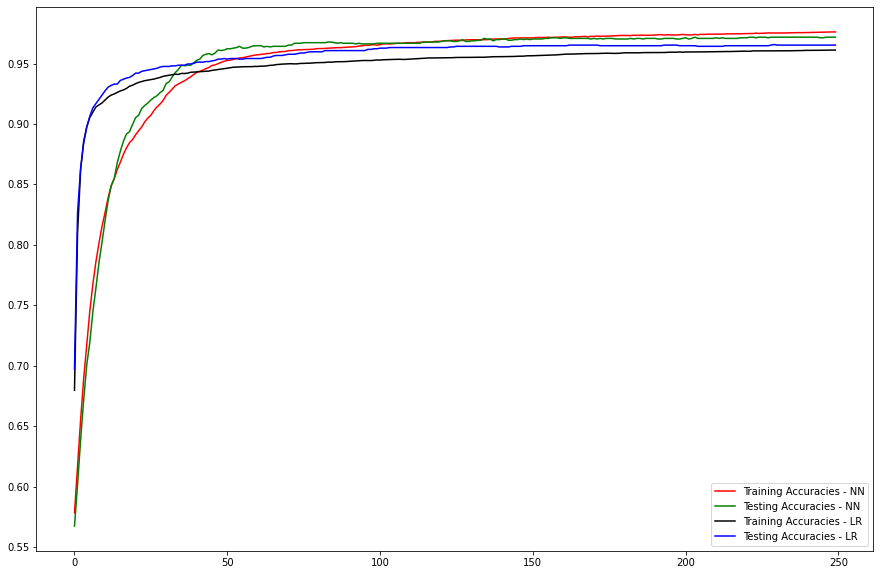

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

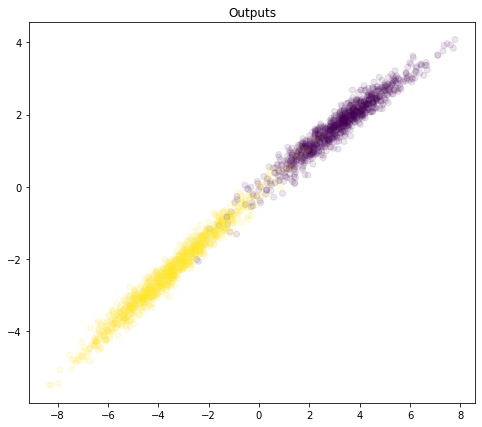

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

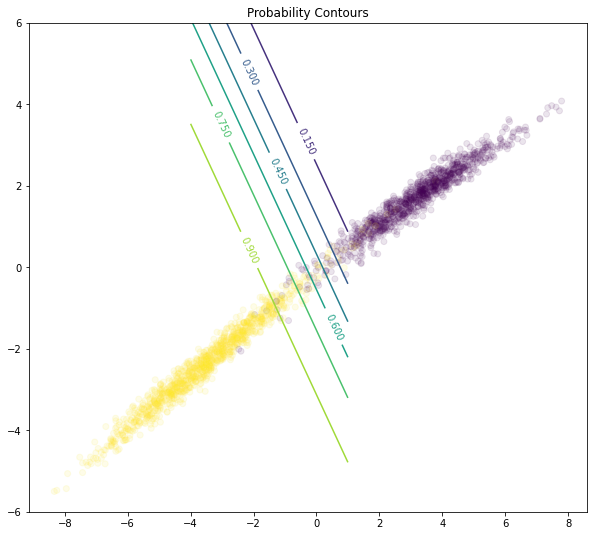

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );